<a href="https://colab.research.google.com/github/shoaibkhanz/so_open-source_survey_analysis/blob/master/Stackoverflow_annual_developer_survey_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow Annual Developer Survey 2019

> Stack Overlow is where everyone goes to get help. It is driven by the community of developers to help the community back.They conduct a survey every year and record all the information about the community and ofcourse the respondent's personal identifiable information is hidden. In 2019 they did it again, their website says the following.

*'with nearly 90,000 responses fielded from over 170 countries and dependent territories, our 2019 Annual Developer Survey examines all aspects of the developer experience from career satisfaction and job search to education and opinions on open source software.'*


### Objective


There are many questions that you may ask out of a survey. Stackoverflow had their own questions and they have published their insights [here](https://insights.stackoverflow.com/survey/2019) and I will encourage you to read it.
I have more own questions but particularly about the opensource world and I will keep it simple and ask just **3** simple questions. 

---

**CAUTION:** For all the questions I ask I am going to assume that the survey users are representative of all the stackoverflow users, 

this assumption should hold true in general.

**Please also follow the Medium blog post to aid your understanding of the analysis done [here](https://medium.com/convergeml/stack-overflow-and-open-source-5ddcd38213f).**

---

**Question 1.** Who are the users of Stackoverflow in **2019** ?

**Question 2.** How soon one can start contributing to **opensource** ?

**Question 3.** If one contributes to opensource will one **earn more** ?  

### Get to know your data

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno #to visualise missing data
import re #for regular expression
#import pdb #for debugging code

pd.set_option('display.float_format', lambda x: '%.2f' % x) #turn off scientific notation
%matplotlib inline

In [0]:
survey2019 = pd.read_csv('/content/drive/My Drive/developer_survey_data/survey_results_public.csv',encoding = "utf-8")

In [68]:
survey2019.head(3)

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.00,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.00,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,THB,Thai baht,23000.00,Monthly,8820.00,40.00,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / 

We must also read the **description** file that helps us understand variable we are trying to explore.

Thus below I **create a function** that returns the description of the column.

In [0]:
survey2019_schema = pd.read_csv('/content/drive/My Drive/developer_survey_data/survey_results_schema.csv')

def get_description(feature_name):
    '''
    input: enter feature name from the data
    output: return the description of the feature    
    
    '''
    print(survey2019_schema[survey2019_schema['Column']==feature_name]['QuestionText'].values[0])
    

In [70]:
#test the get_description function
get_description('Respondent')

Randomized respondent ID number (not in order of survey response time)


In [71]:
print('The Survey 2019 data contains : ')
print(' observations: ',survey2019.shape[0],'\n','features: ',survey2019.shape[1])

The Survey 2019 data contains : 
 observations:  88883 
 features:  85


In [72]:
#data types
survey2019.dtypes.value_counts()

object     79
float64     5
int64       1
dtype: int64

### Visually inspecting for missing values
This is just a visual way to understand the missingness of your data, but this is not enough. We must further look at the missing values to **quantify** them.

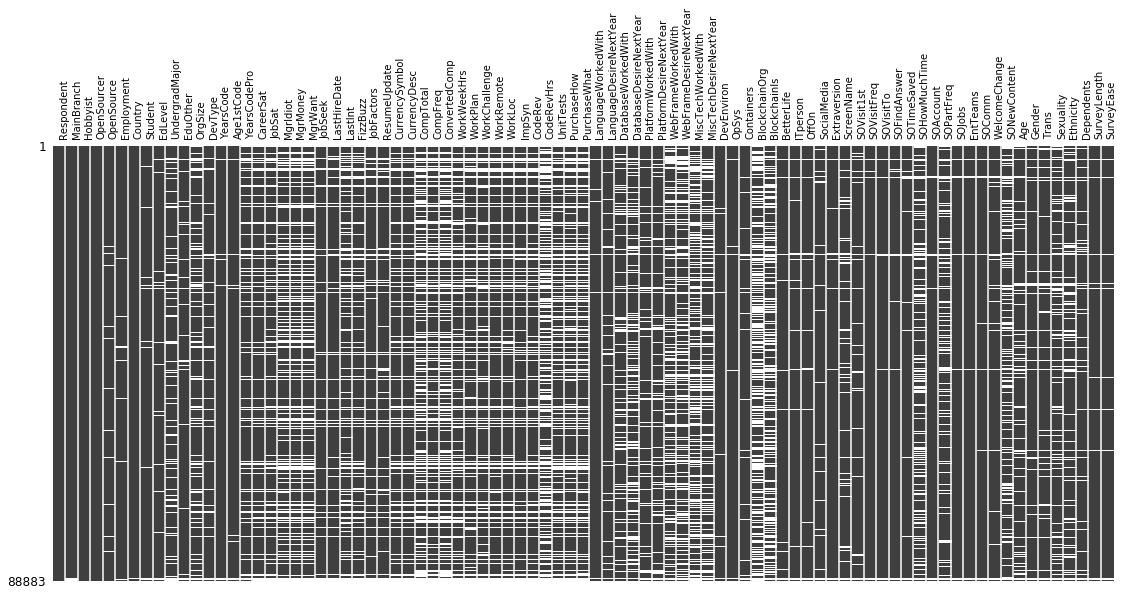

In [73]:
_ = msno.matrix(survey2019, labels = True,fontsize = 10,figsize = (19,8),  sparkline=False) 
plt.xticks(rotation = 90)
plt.show()

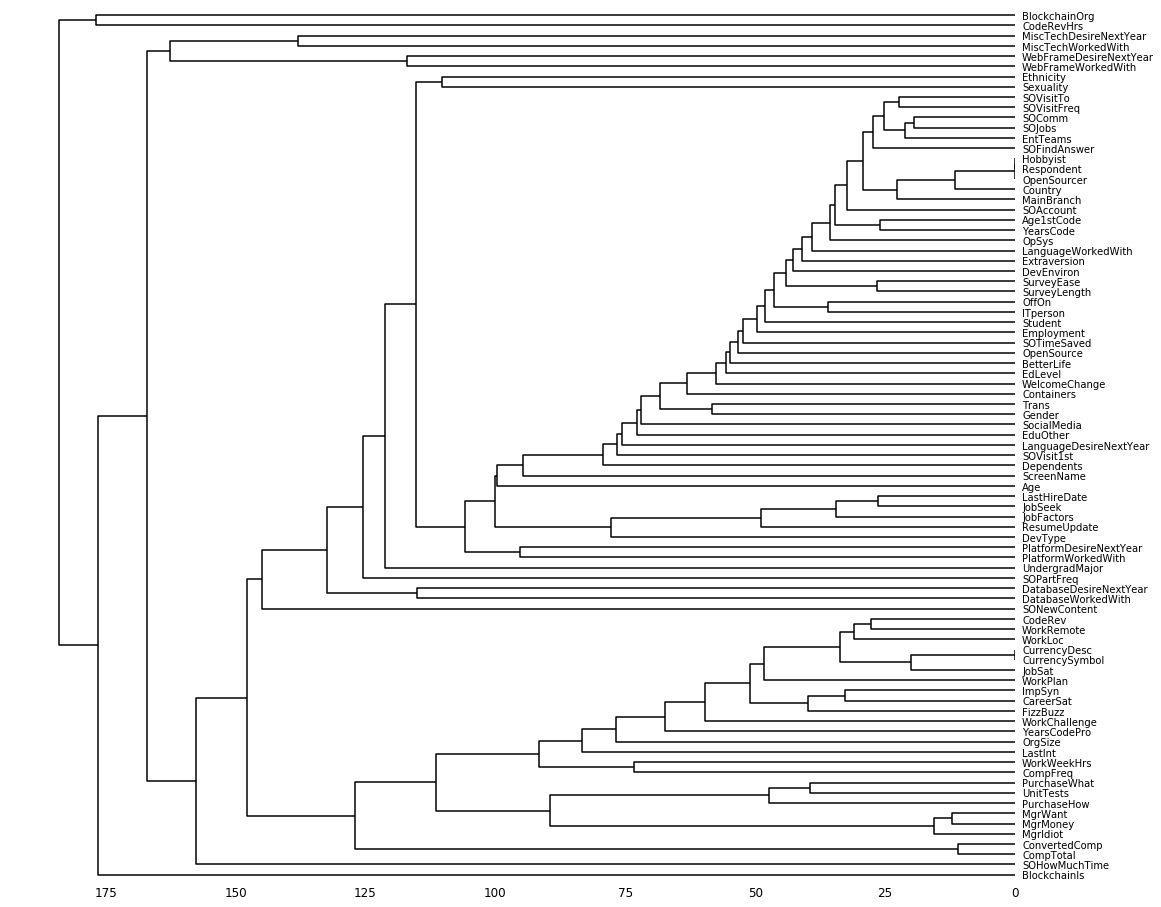

In [74]:
_ = msno.dendrogram(survey2019,fontsize = 10,figsize = (18,16))
plt.show()

From the below bar graph, we know that there are lot of missing values in some of the features like `BlockchainOrg` and `CodeRevHrs` etc.
Approximately, there are **50% features** that consist of missing data beyond **10%**. I also believe we will see some **spurios information** as well and you must not be surprised as this is the case with many surveys.

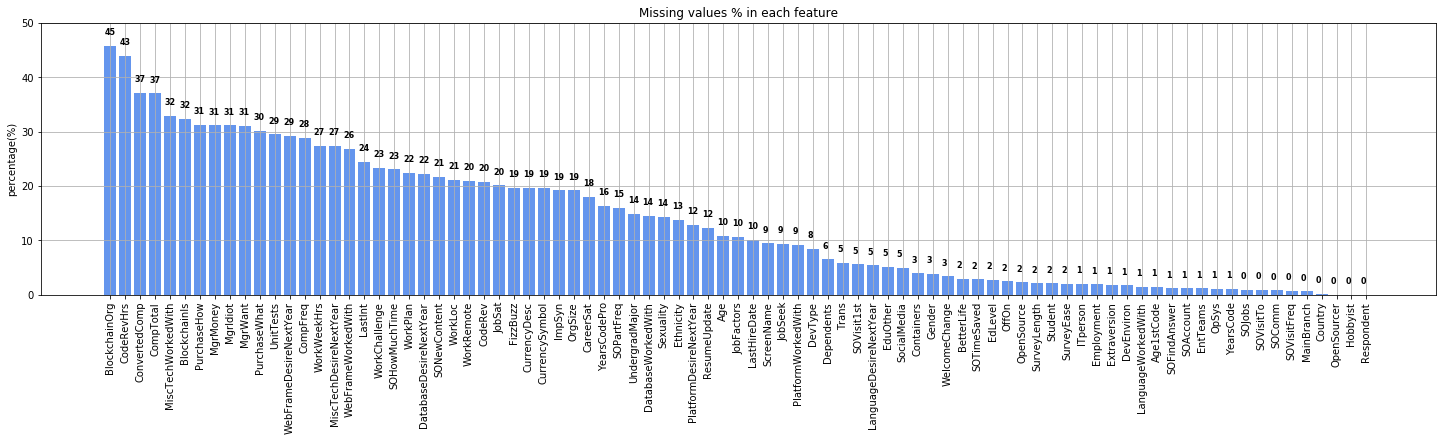

In [75]:
ismissing = survey2019.isnull().sum()
sum(ismissing[ismissing != 0])
ismissing = ismissing/len(survey2019)*100
ismissing.sort_values(ascending=False,inplace=True)

#plotting bar chart of missing values

fig,ax = plt.subplots(figsize=(25,5))
ax.bar(ismissing.index,ismissing.values,color = 'cornflowerblue')
ax.tick_params(axis = 'x',rotation = 90)
ax.set_ylabel('percentage(%)')
ax.set_ylim(top=50)
ax.grid(True)
ax.set_title('Missing values % in each feature')

for i, v in enumerate(ismissing.values):
    ax.text(i - 0.4,v + 2, str(int(v)), color='black',fontsize = 8,fontweight='bold')

plt.show()

## Question 1. Who are the users of Stackoverflow in 2019 ?

We must look at user's **age**, **gender**, **education**, **professional coder in years**, **job title**, **salaries**, **country**, **choice of programming language**, **when did they first code**, **reason for visit**, **visiting frequency**. I believe they should help us to understand the diversity of users that come to stack overflow to seek and give help.

First we must create a **function** to plot continous data as we will be exploring a few continous features in this analysis. The function will help us follow the principles of DRY(Dont repeat yourself), thus I am saving myself some time and maintaining clean code. 



### **Age**

In [76]:
#the following observations will be dropped as age 1-2 looks to be spurious
print(' Dropping observations:',survey2019[survey2019['Age']<=5].shape,'\n',
      'Dropping null observations',survey2019['Age'].isnull().sum())


 Dropping observations: (33, 85) 
 Dropping null observations 9673


In [77]:
#dropping spurious observations here
print('Before dropping',survey2019.shape)
age_ = survey2019[survey2019['Age']>5] #this way we are dropping nulls and as well as age 1 to 2
print('After dropping',age_.shape)

Before dropping (88883, 85)
After dropping (79177, 85)


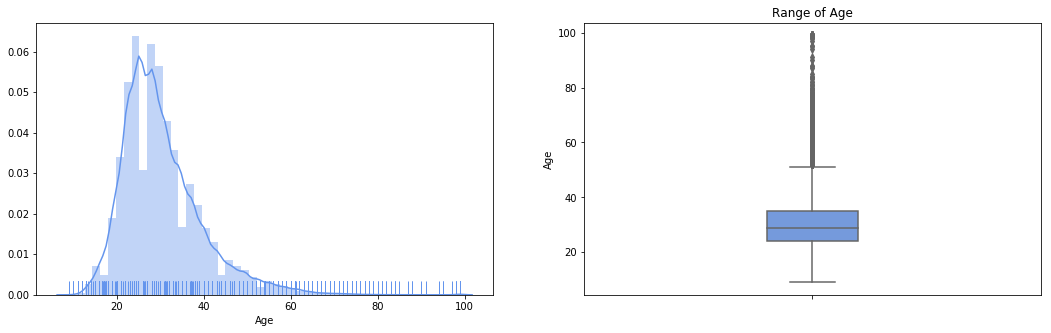

,Age
count,79177.00
mean,30.35
std,9.16
min,9.00
25%,24.00
50%,29.00
75%,35.00
max,99.00


In [78]:
def plot_continous_feat(df,feat,rug = True,kde = True):
    
    '''
    input: dataframe and continous feature name (not for discrete feature)
    output: histogram nd boxplot for the continous variable 
    
    '''
    
    df_ = df[feat].dropna().astype(float)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
    sns.distplot(df_,rug = rug,kde=kde,ax=ax1,color = 'cornflowerblue')
    plt.title('Distribution of '+feat)
    
    _ = sns.boxplot(df_,width = 0.2,orient = 'v',ax=ax2,color = 'cornflowerblue')
    #plt.figtext(0.95,0.5, round(df_.describe(),2).to_string())
    plt.title('Range of '+feat)
    
    plt.show()
    df_show = pd.DataFrame(df_.describe())
    
    return df_show

#plotting histogram and a boxplot
plot_continous_feat(age_,'Age')

### **Gender**

Let's plot `gender` but before I do that I have to do some cleaning. I have a written a `casewhen_gender` function which does exactly that, it cleans! In the fuction, I have segmented the gender into `Man`, `Woman` and `others`.

In [0]:
def casewhen_gender(feat):
    '''
    input: dataframe and the gender column
    output: return new categories
    '''
    
    if feat in ['Man']:
        return str('Man')
    elif feat in  ['Woman']:
        return str('Woman')
    else:
        return str('Others')

survey2019['Gender_new'] = survey2019['Gender'].apply(casewhen_gender)

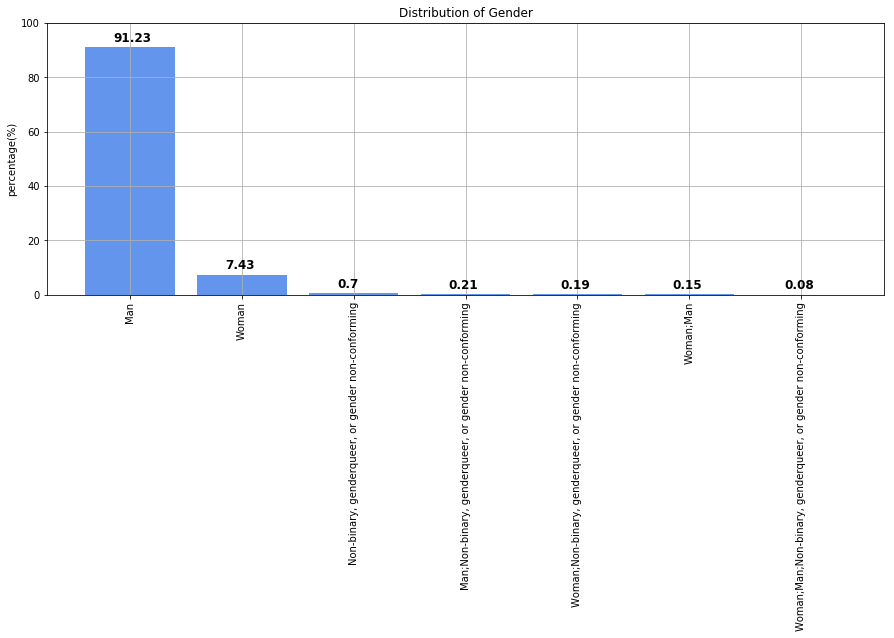

,Gender
Man,77919
Woman,6344
"Non-binary, genderqueer, or gender non-conforming",597
"Man;Non-binary, genderqueer, or gender non-conforming",181
"Woman;Non-binary, genderqueer, or gender non-conforming",163
Woman;Man,132
"Woman;Man;Non-binary, genderqueer, or gender non-conforming",70


In [80]:
def plot_bar(df,feat,normalize = True):
    fig,ax= plt.subplots(figsize = (15,5))
    df_plot = df[feat].value_counts(normalize = normalize)*100
    ax.bar(df_plot.index,df_plot.values,color = 'cornflowerblue')
    ax.set_title('Distribution of '+feat)
    ax.tick_params(axis = 'x',rotation = 90)
    ax.set_ylabel('percentage(%)')
    ax.set_ylim(top=100)
    ax.grid(True)
    
    for i, v in enumerate(df_plot.values):
      ax.text(i-0.15 ,v + 2, str(round(v,2)), color='black',fontsize = 12,fontweight='bold')

    plt.show() 

    df_show = pd.DataFrame(df[feat].value_counts())
    
    
    return df_show

plot_bar(survey2019,'Gender')

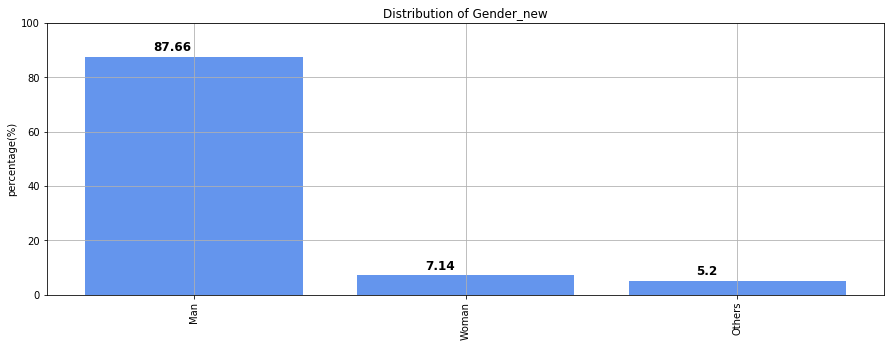

,Gender_new
Man,77919
Woman,6344
Others,4620


In [81]:
#plotting bar chart with cleaned gender variable
plot_bar(survey2019,'Gender_new')

### Education Level

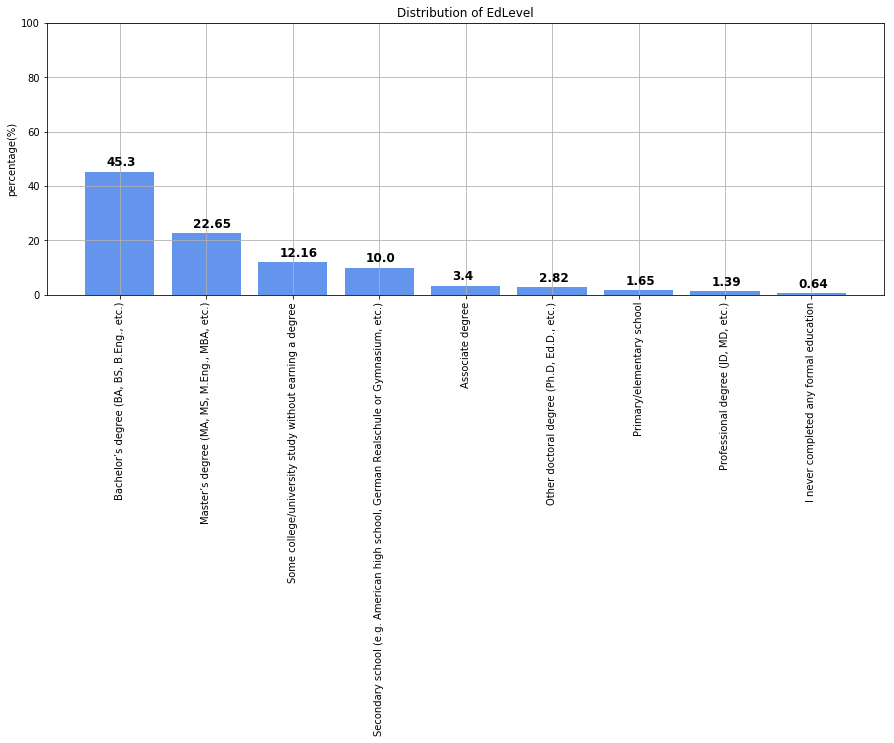

,EdLevel
"Bachelor’s degree (BA, BS, B.Eng., etc.)",39134
"Master’s degree (MA, MS, M.Eng., MBA, etc.)",19569
Some college/university study without earning a degree,10502
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",8642
Associate degree,2938
"Other doctoral degree (Ph.D, Ed.D., etc.)",2432
Primary/elementary school,1422
"Professional degree (JD, MD, etc.)",1198
I never completed any formal education,553


In [82]:
plot_bar(survey2019,'EdLevel')

### Professional Coder

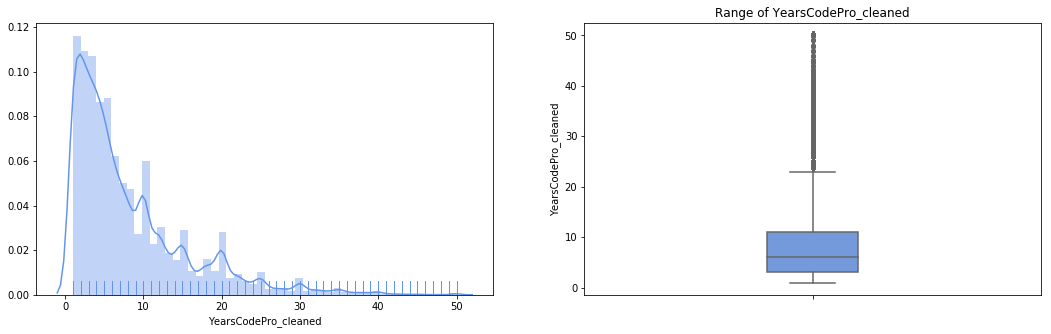

,YearsCodePro_cleaned
count,74331.00
mean,8.21
std,7.60
min,1.00
25%,3.00
50%,6.00
75%,11.00
max,50.00


In [83]:
#~16% missing values and it requires cleaning (extract numbers from text)
survey2019['YearsCodePro_cleaned'] = survey2019['YearsCodePro'].str.extract('(\d+)').astype(float)
plot_continous_feat(survey2019,'YearsCodePro_cleaned')

### **Data Scientist or not**

In [84]:
survey2019['DevType'][:10]

0                                                  NaN
1    Developer, desktop or enterprise applications;...
2    Designer;Developer, back-end;Developer, front-...
3                                Developer, full-stack
4    Academic researcher;Developer, desktop or ente...
5    Data or business analyst;Data scientist or mac...
6                        Designer;Developer, front-end
7       Developer, back-end;Engineer, site reliability
8    Database administrator;Developer, back-end;Dev...
9    Data or business analyst;Data scientist or mac...
Name: DevType, dtype: object

In [0]:
survey2019['DevType_cleaned'] = survey2019['DevType'].str.split(';')
survey2019['DevType_cleaned'] = survey2019['DevType_cleaned'].str.join(',')
survey2019['DevType_cleaned'].fillna('not_known',inplace = True)

def casewhen_ds(feat):
  '''
  input: dataframe and the DevType column
  output: return new data scientist or not

  '''
  #pdb.set_trace()
  if re.findall(r'Data scientist',feat) == ['Data scientist']:
    return str(1)
  else:
    return str(0)

#data scientist or not
survey2019['DS_or_not'] = survey2019['DevType_cleaned'].apply(casewhen_ds)

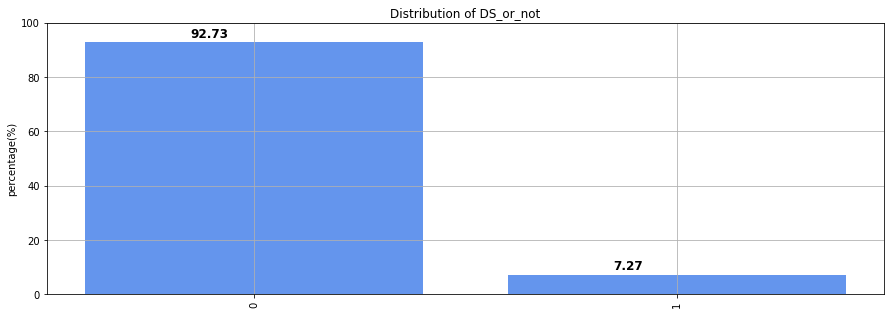

,DS_or_not
0,82423
1,6460


In [86]:
plot_bar(survey2019,'DS_or_not')

### **Salaries**

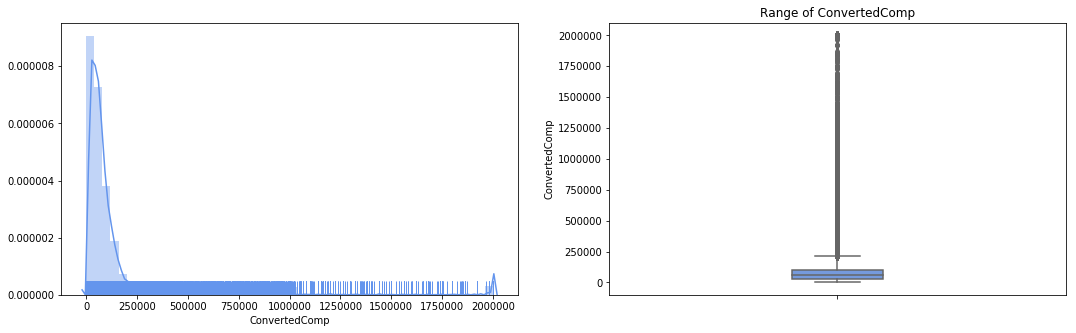

,ConvertedComp
count,55823.00
mean,127110.74
std,284152.30
min,0.00
25%,25777.50
50%,57287.00
75%,100000.00
max,2000000.00


In [87]:
plot_continous_feat(survey2019,'ConvertedComp')

### **Country**

In [88]:
iso_alpha3 = pd.read_csv('/content/drive/My Drive/udacity_DSND/data_science_blog/map_iso_alpha.csv',sep=',')
iso_alpha3.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.00,34.00,nan
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.00,154.00,nan
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.00,39.00,nan
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.00,15.00,nan
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.00,61.00,nan


In [0]:
survey2019 = pd.merge(survey2019,iso_alpha3,how='left',left_on='Country',right_on='name')

In [0]:
country_null_ind =  survey2019['Country'].notnull()
alpha3_null_ind =  survey2019['alpha-3'].notnull()
country_ = survey2019.loc[country_null_ind, ]
country_ = survey2019.loc[alpha3_null_ind, ]
country_= country_.groupby('Country').agg({'alpha-3':np.unique,'region':np.unique,'Respondent':'count'})

In [91]:
#please use google collab if you dont see the output image of a map
fig = px.scatter_geo(country_.reset_index(), locations="alpha-3", color="region",
                     hover_name="Country", size="Respondent",
                     projection="natural earth")
fig.show()

### **Programming Languages**

choice of programming language, when did they first code, reason for visit, visiting frequency.

The next thing we look at are the programming languages that people use. The survey contained this data separated by semicolon. Once again I had to do a bit of cleaning in order to visualise the programming languages that users use. We notice in graphs below thats its actually `Javascript` and `HTML/CSS` that are at the top of the rank and they both represent web and I hope you are not suprised to see them there. In the second place we start seeing languages that support data analytics/science. i.e. `SQL` followed by `Python` which in recent years is not only being used in software engineering but also in data science. `Java` seem to have come down in its ranking as published [here.](https://spectrum.ieee.org/static/interactive-the-top-programming-languages-2019) 

In [92]:
#first 5 examples of LanguageWorkedWith
list(survey2019['LanguageWorkedWith'])[:5]


['HTML/CSS;Java;JavaScript;Python',
 'C++;HTML/CSS;Python',
 'HTML/CSS',
 'C;C++;C#;Python;SQL',
 'C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA']

In [0]:
#cleaning the LanguageWorkedWith column and assigning the cleaned version to 
survey2019['LanguageWorkedWith_cleaned'] = survey2019['LanguageWorkedWith'].fillna('Others')
split_ = []
for i in range(len(survey2019)):
    split_.extend(survey2019['LanguageWorkedWith_cleaned'][i].split(';'))
    
    

In [0]:
from collections import Counter
languages_ = pd.DataFrame.from_dict(Counter(split_),orient='index')
languages_.columns = ['frequency']
languages_.sort_values(by = 'frequency',ascending = False,inplace = True)

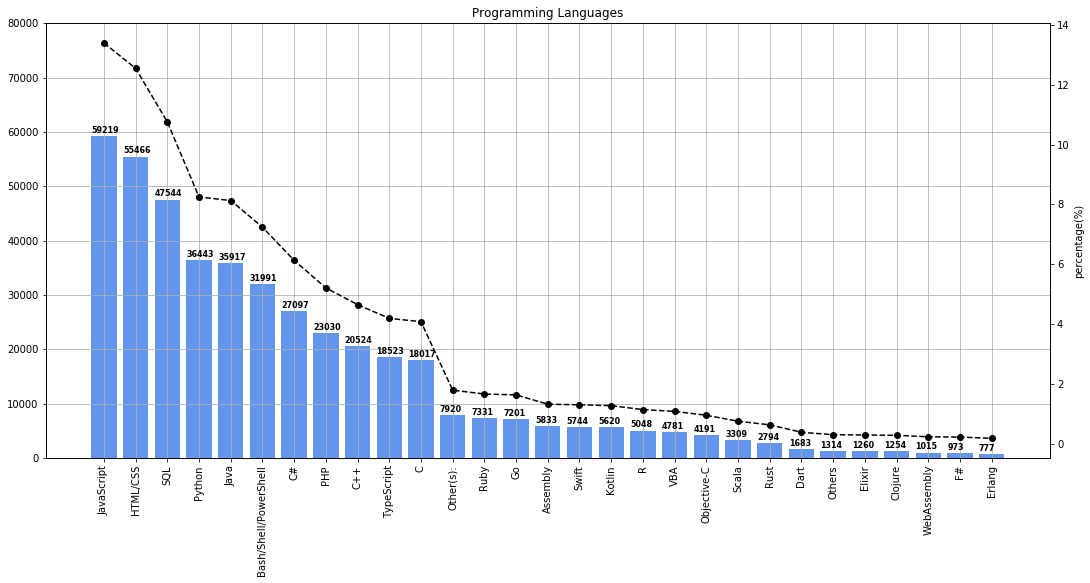

In [95]:
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(languages_.index,languages_['frequency'],color = 'cornflowerblue')
ax2 = ax.twinx()
lang_perc_ = round((languages_['frequency']/languages_['frequency'].sum())*100,2)
ax2.plot(languages_.index,lang_perc_,marker='o',color = 'black',linestyle='--')
ax2.set_ylabel('percentage(%)')
ax.tick_params(axis = 'x',rotation = 90)
ax.set_ylim(top=80000)
ax.grid(True)
ax.set_title('Programming Languages')

for i, v in enumerate(languages_['frequency']):
    ax.text(i-0.4,v + 600, str(int(v)), color='black',fontsize = 8,fontweight='bold')


plt.show()

In summary, stackoverflow users can be as young as 4 years old or as old as 100. Coding has no age restriction, thus no matter how old one is, once shouldnt shrug away from trying to code. We also saw that woman's share as users is very low but we also know that its changing quite rapidly by efforts like `RLadies` and `DjangoGirls`. People love working with Javascript,Python,Java but suprisingly R isnt there in the top 10.

### **First lines of code**

We now look at the `Age1stCode` which represents how soon people have started coding, I had to do some cleaning here as at some places as there were strings in some values. After we have cleaned the data we see that users starts coding as early as, when they are 5 years or as late as 85 years old. This blows my mind, Its pretty incredible to see how diverse age group we have when it comes to coding.

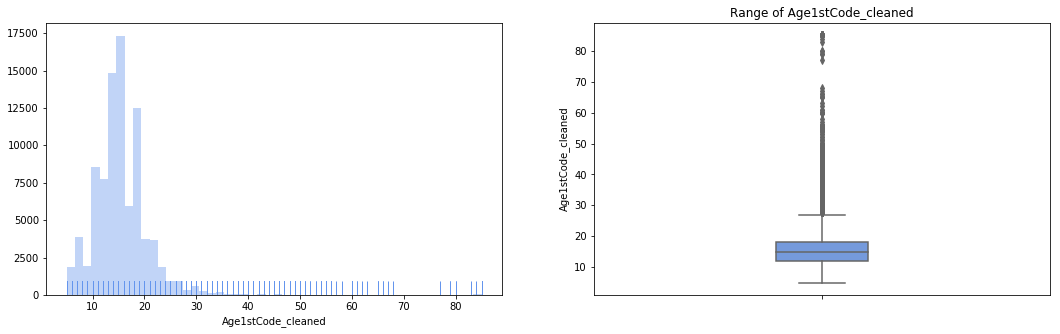

,Age1stCode_cleaned
count,87634.00
mean,15.42
std,5.18
min,5.00
25%,12.00
50%,15.00
75%,18.00
max,85.00


In [96]:
survey2019['Age1stCode_cleaned'] = survey2019['Age1stCode'].str.extract('(\d+)').astype(float)
plot_continous_feat(survey2019,'Age1stCode_cleaned',kde = False)

### **Coding Experience**

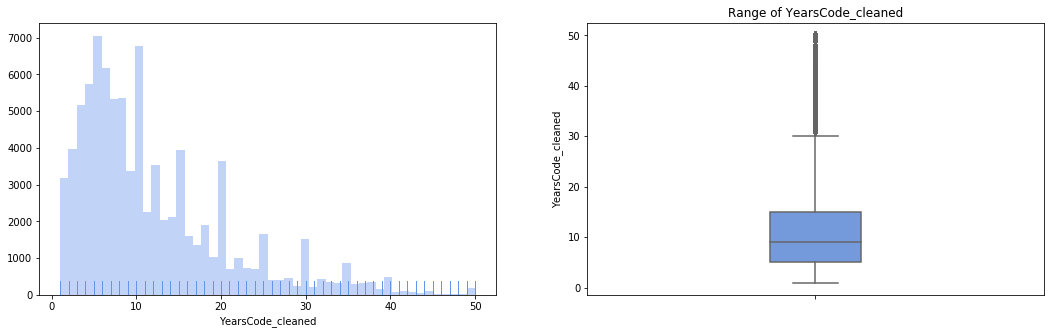

,YearsCode_cleaned
count,87938.00
mean,11.68
std,9.13
min,1.00
25%,5.00
50%,9.00
75%,15.00
max,50.00


In [97]:
survey2019['YearsCode_cleaned'] = survey2019['YearsCode'].str.extract('(\d+)').astype(float)
plot_continous_feat(survey2019,'YearsCode_cleaned',kde = False)

### **Reason for visit (SO)**

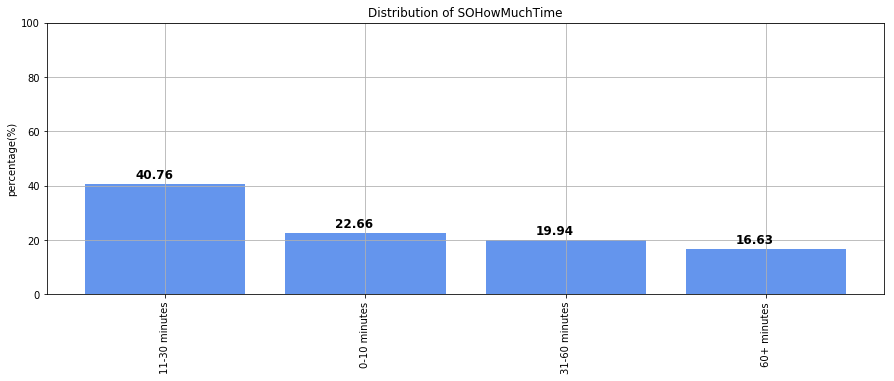

,SOHowMuchTime
11-30 minutes,27872
0-10 minutes,15497
31-60 minutes,13636
60+ minutes,11373


In [98]:
plot_bar(survey2019,'SOHowMuchTime')


### **Visit Frequency**

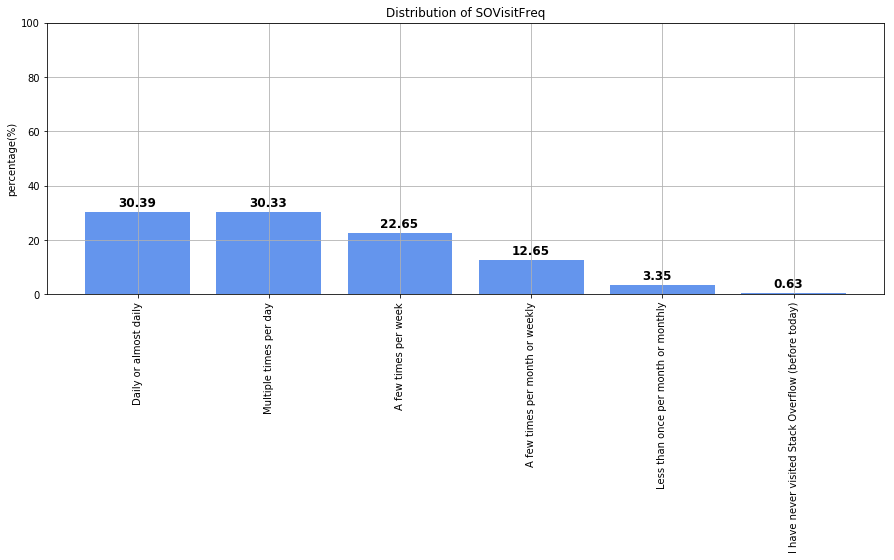

,SOVisitFreq
Daily or almost daily,26827
Multiple times per day,26767
A few times per week,19990
A few times per month or weekly,11162
Less than once per month or monthly,2957
I have never visited Stack Overflow (before today),560


In [99]:
plot_bar(survey2019,'SOVisitFreq')

## Question 2. How soon one can start contributing to opensource ?


To answer this question we need to ask 2 more questions.
* What is the age group of people who contribute to open source ?
* How much time opensource contributers devote to coding ?


### **Opensource**

From the plot below, we can see that roughly 36% of people have never contributed to open source, while around 28% of users are inactive users because they dont contribute every year. If I summarise I would say around 66% of users have contributed to opensource and that is a very large number of people.

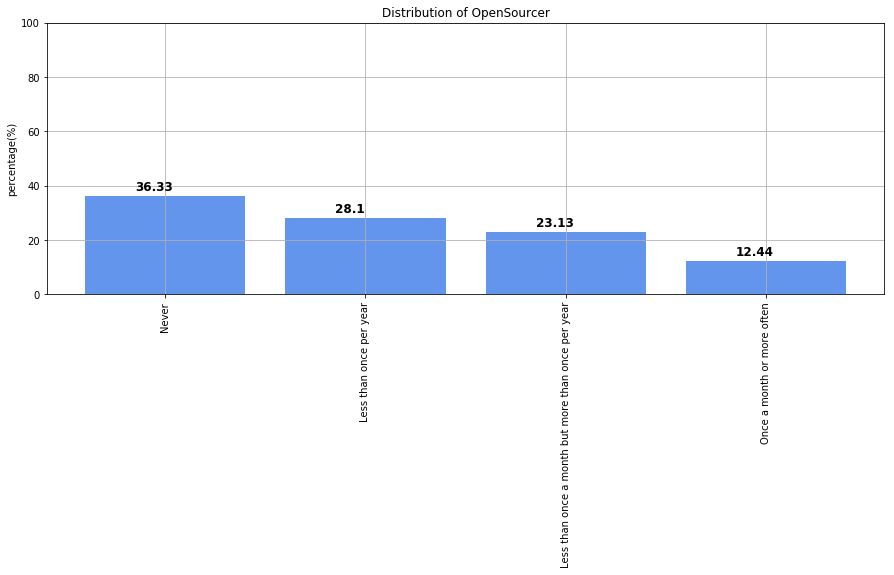

,OpenSourcer
Never,32295
Less than once per year,24972
Less than once a month but more than once per year,20561
Once a month or more often,11055


In [100]:
plot_bar(survey2019,'OpenSourcer')

### **Opensource with Age**

Lets look at age distribution among the people who contribute to open source. The one thing that strikes out is once again there are young children and older people who contribute to open source but their number is extremely tiny. If we further look at the age group we see that users with age `10-20` are also contributing which is brilliant for the community, as they start early and perhaps will continue to contribute as they mature. However, we need to look at how much people who contribute to opensource code in general..

In [101]:
opensource_ = age_.copy(deep = True)
opensource_['OpenSourcer_clean'] = opensource_['OpenSourcer'].map({'Less than once a month but more than once per year':'Slightly_Engaged',
                                                                   'Less than once per year': 'Less_Engaged','Never':'Not_Engaged','Once a month or more often':'Highly_Engaged'}) 
opensource_['age_bin'] = pd.cut(opensource_['Age'],[0,10,20,30,40,50,60,70,80,90,100],
                                labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])
opensourcer_age = opensource_.groupby(['age_bin','OpenSourcer_clean'])['Respondent'].count()
#opensourcer_perc_ = opensourcer_.div(opensourcer_.sum())
opensourcer_age = opensourcer_age.unstack(level=0)
display(opensourcer_age)
print('-'*130)
display(opensourcer_age.apply(lambda x: x/x.sum(),axis = 0))

age_bin,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100
OpenSourcer_clean,,,,,,,,,,
Highly_Engaged,nan,1138.00,4672.00,2668.00,809.00,235.00,49.00,11.00,3.00,1.00
Less_Engaged,nan,1448.00,11125.00,6776.00,2070.00,720.00,165.00,30.00,3.00,9.00
Not_Engaged,1.00,2895.00,15343.00,7076.00,2211.00,843.00,256.00,58.00,7.00,9.00
Slightly_Engaged,3.00,1465.00,9421.00,5530.00,1583.00,415.00,101.00,16.00,1.00,11.00


----------------------------------------------------------------------------------------------------------------------------------


age_bin,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100
OpenSourcer_clean,,,,,,,,,,
Highly_Engaged,nan,0.16,0.12,0.12,0.12,0.11,0.09,0.10,0.21,0.03
Less_Engaged,nan,0.21,0.27,0.31,0.31,0.33,0.29,0.26,0.21,0.30
Not_Engaged,0.25,0.42,0.38,0.32,0.33,0.38,0.45,0.50,0.50,0.30
Slightly_Engaged,0.75,0.21,0.23,0.25,0.24,0.19,0.18,0.14,0.07,0.37


### Opensource with coding experience in years

In [102]:
opensource_['YearsCode_cleaned'] = opensource_['YearsCode'].str.extract('(\d+)').astype(float)
opensourcer_YC = opensource_.groupby(['age_bin','OpenSourcer_clean'])['YearsCode_cleaned'].mean()
opensourcer_YC = opensourcer_YC.unstack(level=0)
opensourcer_YC

age_bin,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100
OpenSourcer_clean,,,,,,,,,,
Highly_Engaged,nan,5.16,8.12,16.71,26.68,33.75,38.18,38.20,16.50,5.00
Less_Engaged,nan,4.62,7.86,15.13,25.26,32.79,37.29,43.90,33.67,16.00
Not_Engaged,nan,3.83,6.71,13.27,22.72,30.26,34.55,40.88,29.17,23.89
Slightly_Engaged,8.33,5.01,8.34,16.20,25.81,33.41,39.53,37.33,50.00,23.30


## Question 3. If one contributes to opensource will one earn more ?


In [0]:
opensource_ = pd.merge(opensource_,survey2019.loc[:,['Respondent','region','alpha-3']],on='Respondent')
opensource_.rename(columns={'OpenSourcer_clean':'opensource_contribution','ConvertedComp':'median_salaries'},inplace = True)
opensource_sal = opensource_.groupby(['Country','alpha-3','region','opensource_contribution']).agg({'Respondent':'count','median_salaries':np.median})
opensource_sal = opensource_sal[opensource_sal['Respondent']>=30]  #keeping only countries that have more than 30 respondents
opensource_sal.drop(['Respondent'],axis = 1,inplace = True)
opensource_sal.reset_index(inplace = True)

In [104]:
fig_sal = px.scatter_geo(opensource_sal, locations="alpha-3", color="region",
                     hover_name="Country", size="median_salaries",animation_frame="opensource_contribution",
                     projection="natural earth")
fig_sal.show()

### Salaries + Open source + Region 

In [105]:
def casewhen_opensource(feat):
  '''
  input: dataframe and the opensource_contribution column
  output: return new categories
  '''
  if feat == 'Not_Engaged':
    return 'opensource_no'
  else:
    return  'opensource_yes'

opensource_['opensource_yesno'] = opensource_['opensource_contribution'].apply(casewhen_opensource) 
opensource_yesno = opensource_.groupby(['Country','alpha-3','region','opensource_yesno']).agg({'Respondent':'count','median_salaries':np.median})
opensource_yesno = opensource_yesno[opensource_yesno['Respondent']>=30]  #keeping only countries that have more than 30 respondents
opensource_yesno.drop(['Respondent'],axis = 1,inplace = True)

display(opensource_.groupby(['opensource_yesno']).agg({'median_salaries':np.median}))
print('-'*50)
opensource_.groupby(['region','opensource_yesno']).agg({'median_salaries':np.median}).unstack()


,median_salaries
opensource_yesno,
opensource_no,51000.00
opensource_yes,60000.00


--------------------------------------------------


median_salaries               
opensource_yesno   opensource_no opensource_yes
region                                         
Africa                  13140.00       13296.00
Americas                83972.00       99240.00
Asia                    12900.00       14692.00
Europe                  43538.00       53700.00
Oceania                 68903.00       79783.00

In [106]:
opensource_yesno_map= opensource_.groupby(['Country','alpha-3','region','opensource_yesno']).agg({'Respondent':'count','median_salaries':np.median})
opensource_yesno_map = opensource_yesno_map[opensource_yesno_map['Respondent']>=30].reset_index()  #keeping only countries that have more than 30 respondents
opensource_yesno_map.drop(['Respondent'],axis = 1,inplace = True)
opensource_yesno_map.sort_values(by='median_salaries',ascending=False).head()

,Country,alpha-3,region,opensource_yesno,median_salaries
159,United States,USA,Americas,opensource_yes,120000.00
158,United States,USA,Americas,opensource_no,100000.00
73,Israel,ISR,Asia,opensource_yes,96240.00
142,Switzerland,CHE,Europe,opensource_yes,95440.00
141,Switzerland,CHE,Europe,opensource_no,90417.00


In [107]:
#please use google collab if you dont see the output image of a map
fig_opensource = px.scatter_geo(opensource_yesno_map, locations="alpha-3", color="region",
                     hover_name="Country", size="median_salaries",animation_frame="opensource_yesno",
                     projection="natural earth")
fig_opensource.show()

##Summary

Stack overflow is a great community where people come from different age groups, countries, education etc. Age is not the barrier to start coding. 
We also saw in this analysis that although open source is practiced with more experienced individuals the difference is not very large but the returns are. The Salaries are higher if you contribute to open source.

